In [84]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import logging
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

logger = logging.getLogger()

In [96]:
X_data_directory = "/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

In [11]:
y = pd.read_csv("../../data/histopathologic-cancer-detection/train_labels.csv")

In [12]:
y.shape

(220025, 2)

In [13]:
y.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [14]:
y_train.groupby('label').count()

,id
label,
0,130908
1,89117


/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:937: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(x, *args, **kwargs)


""
label
0
1


### Sort labels in alphanumeric order

In [19]:
y_train_sorted = y_train.sort_values('id')

In [20]:
y_train_sorted.head()

,id,label
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
16166,000020de2aa6193f4c160e398a8edea95b1da598,0
87832,00004aab08381d25d315384d646f5ce413ea24b1,0
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
128953,0000da768d06b879e5754c43e2298ce48726f722,1


In [21]:
y_train_sorted.tail()

,id,label
175454,fffe6c73afcf5f5da5818fb70cb723026b172eca,0
168161,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0
39707,fffeca85b16452a7709d163e05a70e646782b3cc,1
208140,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1
129173,ffffe55093358954f38bba4c35b6aa0ece86177c,0


### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [ ]:
y_train_sorted.loc[y_train_sorted['label'] == 0,'translated_label'] = 'False'
y_train_sorted.loc[y_train_sorted['label'] == 1,'translated_label'] = 'True'

y_train_sorted["file_name"] = y_train_sorted["id"].astype(str) + ".tif"

In [62]:
y_train_sorted.iloc[[0]]

,id,label,translated_label,file_name
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif


/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-canc

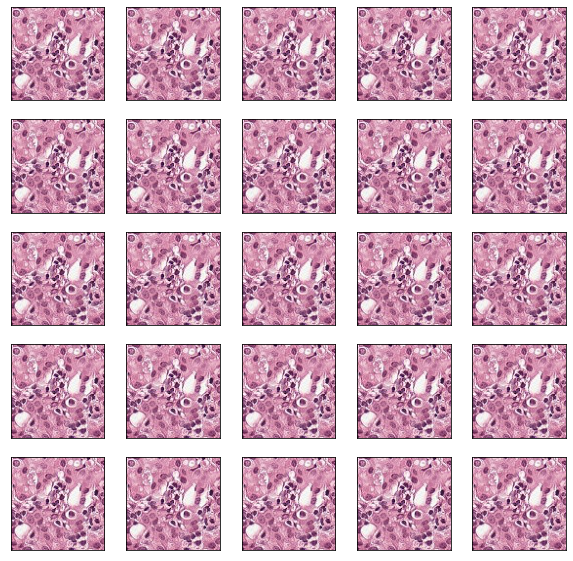

In [98]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = y_train_sorted.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    current_file_name = current_row['file_name']
    curr_file_path = f"{X_data_directory}{current_file_name}"
    curr_file_path = "/Users/simonameriam/PycharmProjects/data_sciense_keras_project/data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif"
    print(curr_file_path)
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)
#        

#         plt.xlabel(str(current_row['translated_label']))
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


## Load image train set

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [48]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [58]:
datagen = ImageDataGenerator(rescale=1./255)

Found 220025 validated image filenames belonging to 2 classes.


In [60]:
train_set = datagen.flow_from_dataframe(
        dataframe=y_train_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42,
        validation_split=0.3,
        subset="training",
        class_mode='binary') 

val_set = datagen.flow_from_dataframe(
        dataframe=y_train_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42,
        validation_split=0.3,
        subset="validation",
        class_mode='binary') 

Found 220025 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 2 classes.
